# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings_Augmented/autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1    2    3         4    5    6    7         8  \
41001 201546 -1.0  0.647343 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -0.969856   
      201547 -1.0  0.466803 -1.0 -1.0  0.070479 -1.0 -1.0 -1.0 -0.895537   
      201548 -1.0  0.466803 -1.0 -1.0  0.070479 -1.0 -1.0 -1.0 -0.895537   
      201549 -1.0 -0.885764 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -1.000000   
      201550 -1.0  0.570663 -1.0 -1.0  0.499102 -1.0 -1.0 -1.0 -0.883193   

                     9  ...  1015  1016      1017  1018  1019  1020  1021  \
41001 201546 -1.000000  ...  -1.0  -1.0 -1.000000  -1.0  -1.0  -1.0  -1.0   
      201547 -0.078951  ...  -1.0  -1.0 -0.128724  -1.0  -1.0  -1.0  -1.0   
      201548 -0.078951  ...  -1.0  -1.0 -0.128724  -1.0  -1.0  -1.0  -1.0   
      201549 -1.000000  ...  -1.0  -1.0 -1.000000  -1.0  -1.0  -1.0  -1.0   
      201550 -1.000000  ...  -1.0  -1.0  0.267194  -1.0  -1.0  -1.0  -1.0   

              1022  1023    Labels  
41001 201546  -1.0  -1.0 -0.861740  
      201547  -1.0  -1.0 -0.854589  
      201548  -1.0  -1.0 -0.856973  
      201549  -1.0  -1.0 -0.856973  
      201550  -1.0  -1.0 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1    2         3         4    5    6    7         8  \
41001 201820 -1.0  0.115897 -1.0 -1.000000 -1.000000 -1.0 -1.0 -1.0 -0.642762   
      201821 -1.0  0.466863 -1.0 -0.135766 -0.530209 -1.0 -1.0 -1.0 -0.917781   
      201822 -1.0  0.137742 -1.0 -0.411660 -0.889752 -1.0 -1.0 -1.0 -0.861268   
      201823 -1.0 -1.000000 -1.0 -1.000000 -1.000000 -1.0 -1.0 -1.0 -0.501658   
      201824 -1.0  0.153936 -1.0 -0.220366 -1.000000 -1.0 -1.0 -1.0 -0.720657   

                9  ...  1015      1016      1017  1018      1019  1020  1021  \
41001 201820 -1.0  ...  -1.0  0.225644 -1.000000  -1.0 -1.000000  -1.0  -1.0   
      201821 -1.0  ...  -1.0 -0.171905 -0.794141  -1.0 -1.000000  -1.0  -1.0   
      201822 -1.0  ...  -1.0  0.121707 -1.000000  -1.0 -1.000000  -1.0  -1.0   
      201823 -1.0  ...  -1.0 -0.351482 -1.000000  -1.0 -0.881386  -1.0  -1.0   
      201824 -1.0  ...  -1.0  0.522492 -1.000000  -1.0 -1.000000  -1.0  -1.0   

              1022  1023    Labels  
41001 201820  -1.0  -1.0 -0.949940  
      201821  -1.0  -1.0 -0.961859  
      201822  -1.0  -1.0 -0.940405  
      201823  -1.0  -1.0 -0.961859  
      201824  -1.0  -1.0 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

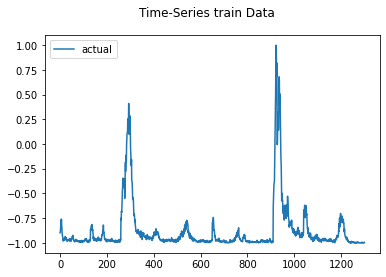

2023-03-13 21:23:11.827484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 21:23:11.827523: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:23:11.827545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-13 21:23:11.827738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:23:11.898357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 37.511
Test RMSE: 44.745
Test sMAPE: 95.252
Test R Squared: -1.072
{'mae': 37.51092524239511, 'rmse': 44.74508910290526, 'smape': 95.2518427922739, 'r2': -1.0717280976078065}


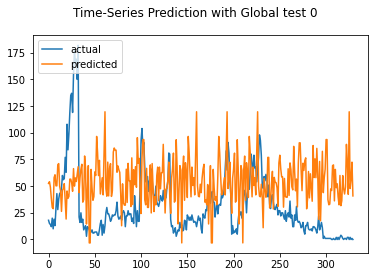

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 36.393
Test RMSE: 47.386
Test sMAPE: 100.715
Test R Squared: -1.324
{'mae': 36.392767909078884, 'rmse': 47.38621953584445, 'smape': 100.71511742902874, 'r2': -1.323518453162262}


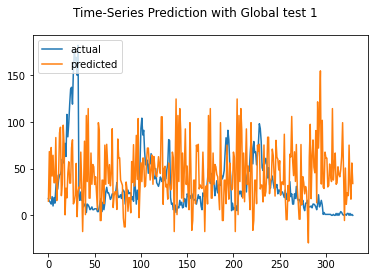

Test MAE: 41.641
Test RMSE: 52.634
Test sMAPE: 94.315
Test R Squared: -1.867
{'mae': 41.640797435876095, 'rmse': 52.63384579577433, 'smape': 94.314520360397, 'r2': -1.866633746697882}


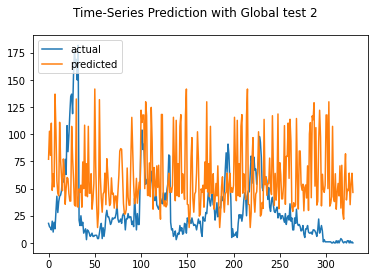

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 40.037
Test RMSE: 48.618
Test sMAPE: 101.928
Test R Squared: -1.446
{'mae': 40.03749713735147, 'rmse': 48.61760246167263, 'smape': 101.92840678384968, 'r2': -1.4458458269626369}


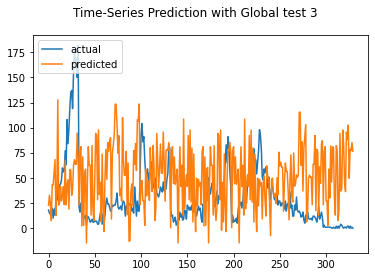

Test MAE: 56.989
Test RMSE: 66.030
Test sMAPE: 112.619
Test R Squared: -3.512
{'mae': 56.98893994923794, 'rmse': 66.03023109193381, 'smape': 112.61877029376271, 'r2': -3.511569334853121}


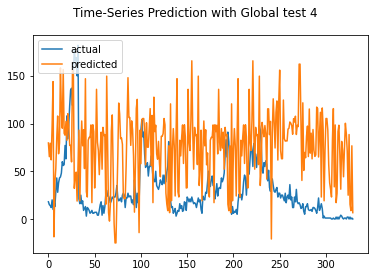

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 33.242
Test RMSE: 41.064
Test sMAPE: 93.464
Test R Squared: -0.745
{'mae': 33.24209695458412, 'rmse': 41.064299619018804, 'smape': 93.46369371974467, 'r2': -0.7449012015789862}


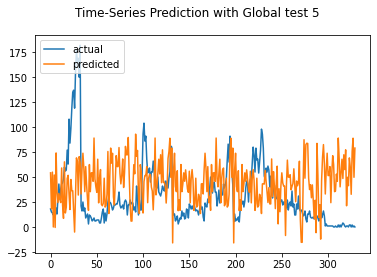

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 38.016
Test RMSE: 46.177
Test sMAPE: 96.642
Test R Squared: -1.206
{'mae': 38.01592353040522, 'rmse': 46.17652715709811, 'smape': 96.64201618554819, 'r2': -1.2064014613209855}


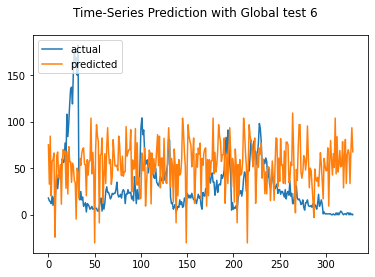

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 40.955
Test RMSE: 52.119
Test sMAPE: 102.975
Test R Squared: -1.811
{'mae': 40.95470059748852, 'rmse': 52.11856797511494, 'smape': 102.97505066056604, 'r2': -1.810780620027964}


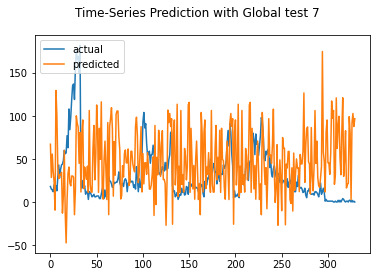

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 27.821
Test RMSE: 39.658
Test sMAPE: 97.826
Test R Squared: -0.627
{'mae': 27.82142215741403, 'rmse': 39.65779374471729, 'smape': 97.82605430409573, 'r2': -0.6274179473047992}


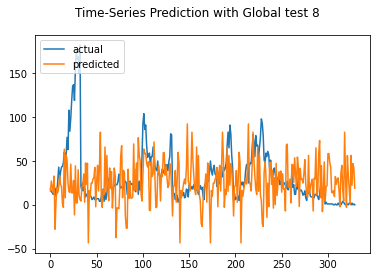

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 35.727
Test RMSE: 44.919
Test sMAPE: 94.455
Test R Squared: -1.088
{'mae': 35.72739498001157, 'rmse': 44.91862688541671, 'smape': 94.45457824939353, 'r2': -1.0878290949745097}


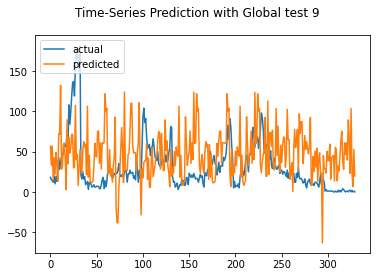

Test MAE: 51.108
Test RMSE: 69.973
Test sMAPE: 125.616
Test R Squared: -4.066
{'mae': 51.107751965884006, 'rmse': 69.97293217832652, 'smape': 125.6159923387467, 'r2': -4.0664311826845765}


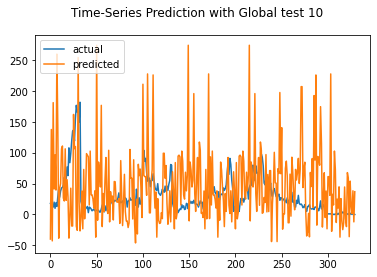

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 37.287
Test RMSE: 49.582
Test sMAPE: 101.560
Test R Squared: -1.544
{'mae': 37.28722181428562, 'rmse': 49.58220649094334, 'smape': 101.56049854773799, 'r2': -1.543862896987846}


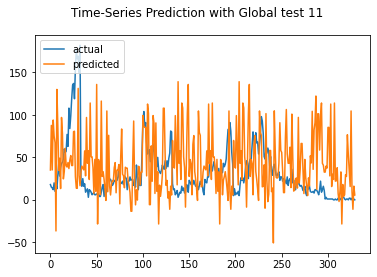

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 38.654
Test RMSE: 46.914
Test sMAPE: 95.799
Test R Squared: -1.277
{'mae': 38.654073576493694, 'rmse': 46.913764508440856, 'smape': 95.79938167566118, 'r2': -1.2774170551336543}


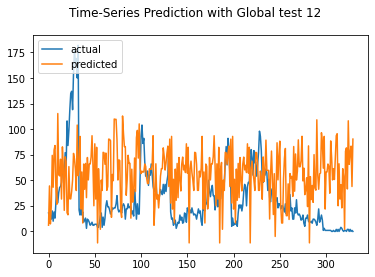

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 33.778
Test RMSE: 43.987
Test sMAPE: 89.518
Test R Squared: -1.002
{'mae': 33.777943059440815, 'rmse': 43.987358153859624, 'smape': 89.51847685723817, 'r2': -1.0021552967734921}


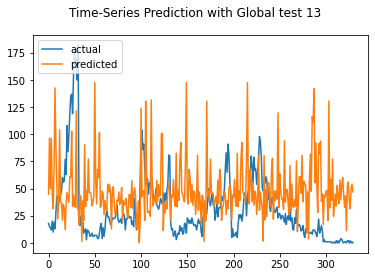

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 33.456
Test RMSE: 42.414
Test sMAPE: 105.949
Test R Squared: -0.861
{'mae': 33.45578323774266, 'rmse': 42.413722258768885, 'smape': 105.94932931761097, 'r2': -0.861464584522543}


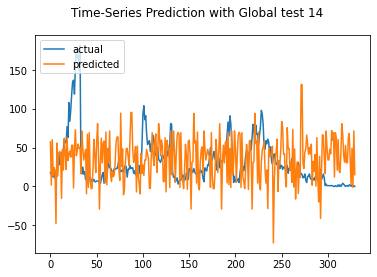

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 42.819
Test RMSE: 52.344
Test sMAPE: 111.991
Test R Squared: -1.835
{'mae': 42.819329448541005, 'rmse': 52.3441068378079, 'smape': 111.99132809379127, 'r2': -1.8351601051697273}


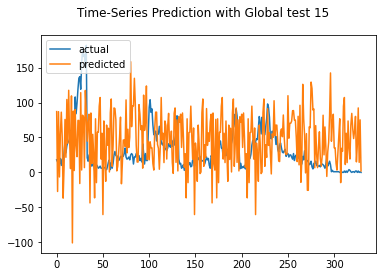

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 35.019
Test RMSE: 45.757
Test sMAPE: 105.284
Test R Squared: -1.167
{'mae': 35.01936826904615, 'rmse': 45.757226831662344, 'smape': 105.28436378905575, 'r2': -1.1665134673571047}


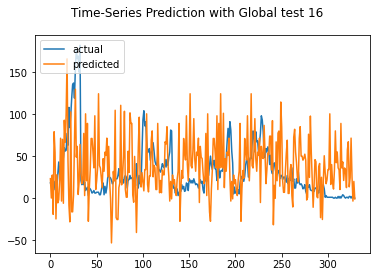

Test MAE: 64.014
Test RMSE: 75.260
Test sMAPE: 112.164
Test R Squared: -4.861
{'mae': 64.01356923291178, 'rmse': 75.25969246233407, 'smape': 112.16361698192067, 'r2': -4.860934667484366}


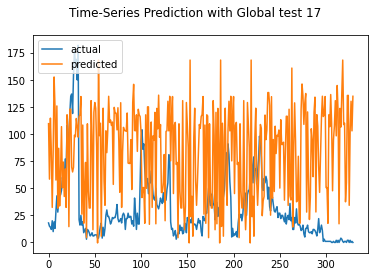

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 41.984
Test RMSE: 50.434
Test sMAPE: 97.498
Test R Squared: -1.632
{'mae': 41.98370487906716, 'rmse': 50.433665467250826, 'smape': 97.4983772952418, 'r2': -1.6319829308819362}


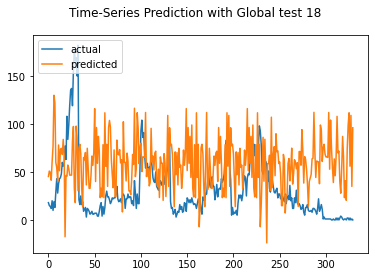

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 29.442
Test RMSE: 37.976
Test sMAPE: 89.648
Test R Squared: -0.492
{'mae': 29.441987781271795, 'rmse': 37.97613543226145, 'smape': 89.64809409168595, 'r2': -0.49232541982798317}


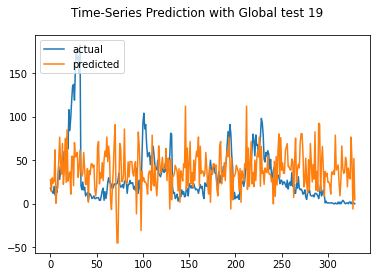

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 30.475
Test RMSE: 41.707
Test sMAPE: 87.239
Test R Squared: -0.800
{'mae': 30.474888823610364, 'rmse': 41.70651601854012, 'smape': 87.23888013431993, 'r2': -0.799906006395313}


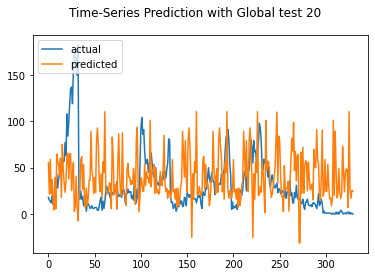

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 49.621
Test RMSE: 57.155
Test sMAPE: 106.394
Test R Squared: -2.380
{'mae': 49.62088753093373, 'rmse': 57.15455309000522, 'smape': 106.39445036469971, 'r2': -2.3802098898890076}


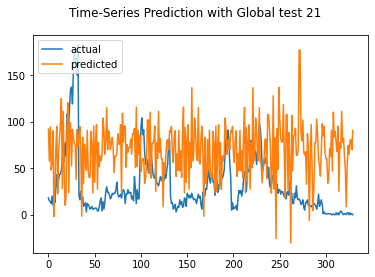

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 30.806
Test RMSE: 40.574
Test sMAPE: 108.949
Test R Squared: -0.703
{'mae': 30.806479073835142, 'rmse': 40.573809390932304, 'smape': 108.9491464756188, 'r2': -0.7034663967339072}


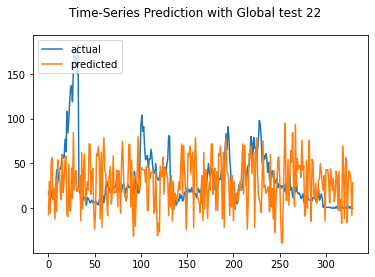

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 42.467
Test RMSE: 56.479
Test sMAPE: 98.169
Test R Squared: -2.301
{'mae': 42.46728601527936, 'rmse': 56.47867225585817, 'smape': 98.16946894405132, 'r2': -2.300737281588054}


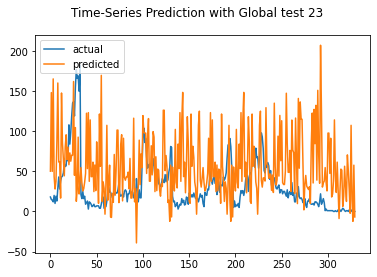

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 32.876
Test RMSE: 41.835
Test sMAPE: 91.181
Test R Squared: -0.811
{'mae': 32.87631703940305, 'rmse': 41.83477014174019, 'smape': 91.18054576249294, 'r2': -0.8109930178143072}


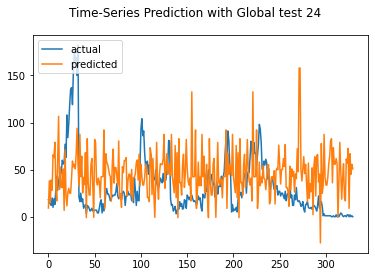

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 34.152
Test RMSE: 42.945
Test sMAPE: 100.565
Test R Squared: -0.908
{'mae': 34.1521905299389, 'rmse': 42.94502160143335, 'smape': 100.56462835020132, 'r2': -0.9083922873704697}


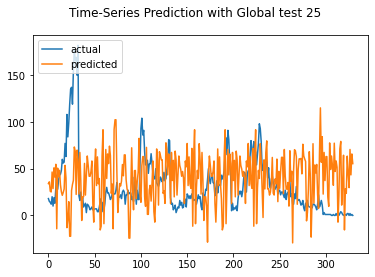

Test MAE: 47.420
Test RMSE: 59.343
Test sMAPE: 98.278
Test R Squared: -2.644
{'mae': 47.42037932619904, 'rmse': 59.34253739380136, 'smape': 98.27755457335961, 'r2': -2.6439652430301055}


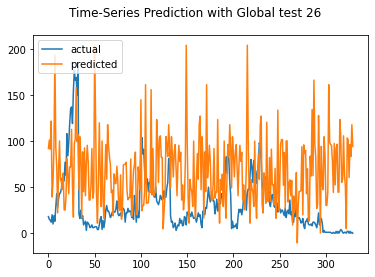

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')